# Feature-Based Support Vector Machine using Hinge Loss
Here, we will train a feature-based SVM on the two moons dataset using the hinge loss. We will use the L-BFGS-B algorithm, provided by `scipy.optimize` for the optimization. All you need to know about this optimizer is that it is gradient-based. Otherwise, you can treat it as a black box. Yet, it's also worth a closer look if you are interested. 

We start by loading the data.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

## load data
train_data = dict(np.load("two_moons.npz", allow_pickle=True))
train_samples = train_data["samples"]
train_labels = train_data["labels"]

test_data = dict(np.load("two_moons_test.npz", allow_pickle=True))
test_samples = test_data["samples"]
test_labels = test_data["labels"]

Opposed to logistic regression, an SVMs work with labels $-1$ and $1$, not $0$ and $1$. So let's change the label of the $0$-class.

In [2]:
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
train_labels_svm = train_labels.copy()
train_labels_svm[train_labels_svm == 0] = -1 
# we need to change the labels for class 0 to -1 to account for the different labels used by an SVM 
test_labels_svm = test_labels.copy()
test_labels_svm[test_labels_svm == 0] = -1

Let's also visualize the data once more. 

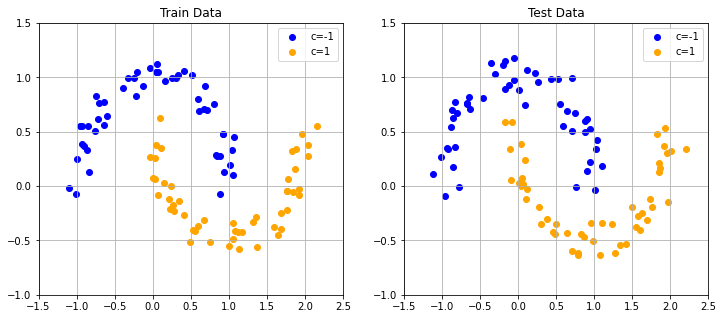

In [3]:

## plot data
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Train Data")
plt.scatter(x=train_samples[train_labels_svm == -1, 0], 
            y=train_samples[train_labels_svm == -1, 1], label="c=-1", c="blue")
plt.scatter(x=train_samples[train_labels_svm == 1, 0], 
            y=train_samples[train_labels_svm == 1, 1], label="c=1", c="orange")

plt.legend()
plt.subplot(1, 2, 2)
plt.grid("on")
plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)
plt.title("Test Data")
plt.scatter(x=test_samples[test_labels_svm == -1, 0], 
            y=test_samples[test_labels_svm == -1, 1], label="c=-1", c="blue")
plt.scatter(x=test_samples[test_labels_svm == 1, 0],
            y=test_samples[test_labels_svm == 1, 1], label="c=1", c="orange")

plt.legend()

We use cubic features $\phi(\boldsymbol x)$, as we previously saw that they work quite well or the two moons data. Let us define a function to compute those features.

In [4]:
def cubic_feature_fn(samples: np.ndarray) -> np.ndarray:
    """
    :param x: Batch of 2D data vectors [x, y] [N x dim]
    :return cubic features: [x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, 1]
    """
    x = samples[..., 0]
    y = samples[..., 1]
    return np.stack([x**3, y**3, x**2 * y, x * y**2, x**2, y**2, x*y, x, y, np.ones(x.shape[0])], axis=-1)

## Hinge Loss Objective

First, we need to implement the hinge loss objective. Its given by 
 $$\mathcal{L}_{\boldsymbol{X}, \boldsymbol{y}}(\boldsymbol w) = \parallel \boldsymbol{w} \parallel^2 + C \sum_i^N  \max \left( 0, 1 - y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) \right),$$
 where $\boldsymbol{w}$ are our model parameters, $\phi(\boldsymbol{x})$ are our cubic features and the $y_i \in \lbrace{-1, 1\rbrace}$ are the class labels. 
 

In [5]:
def objective_svm(weights: np.ndarray, 
                  features: np.ndarray,
                  labels: np.ndarray, 
                  slack_regularizer: float) -> float:
    """
    objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape:[N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: factor to weigh the violation of margin with (C in slides)
    :returns svm (hinge) objective (shape: scalar)
    """
    predictions = features @ weights
    hinge_loss = np.sum(np.maximum(0, 1 - labels * predictions))
    reg_loss = np.dot(weights, weights) 
    return reg_loss + slack_regularizer * hinge_loss

##  Hinge Loss Gradient

As we want to use gradient based optimization, we clearly also need the gradient of the hinge loss w.r.t. the parameters $\boldsymbol{w}$. This gradient is given by 

$$\dfrac{\partial \mathcal{L}_{\boldsymbol{X},  \boldsymbol{y}}(\boldsymbol{w})}{\partial\boldsymbol{w}} = 2\boldsymbol{w} + C \sum_i^N d_{\mathrm{hinge}, i} $$ 
 with $$d_{\mathrm{hinge}, i} = - y_i \phi(\boldsymbol{x}_i) \quad \text{if} \quad y_i \boldsymbol{w}^T \phi(\boldsymbol{x}_i) < 1  \quad \text{else} \quad 0 $$
 
**Note:** we set the subgradient at the non-differentiable point to 0. You can also replace $<$ in the last line by $\leq$, i.e., choose the subgradient to be $- y_i \phi(\boldsymbol{x}_i)$ at the non-differentiable point. Anything in between would also be a valid subgradient, but only unnecessarily complicate things as the chance of ending up at exactly that point is zero anyway).

In [6]:
def d_objective_svm(weights: np.ndarray, features: np.ndarray, labels: np.ndarray, slack_regularizer: float) -> np.ndarray:
    """
    gradient of objective for svm training with hinge loss
    :param weights: current weights to evaluate (shape: [feature_dim])
    :param features: features of training samples (shape: [N x feature_dim])
    :param labels: class labels corresponding to train samples (shape: [N])
    :param slack_regularizer: factor to weigh the violation of margin with (C in slides)
    :returns gradient of svm objective (shape: [feature_dim])
    """
    l = np.expand_dims(labels * (features @ weights), 1)
    d_hinge = np.sum(np.where(l < 1, - np.expand_dims(labels, 1) * features, 0), axis=0)
    return 2 * weights + slack_regularizer * d_hinge

## Logistic Regression Loss and Gradient (for later comparision)

This is copied from the first exercise. The only change is a ridge term, which was introduced to make the optimization stable 

In [7]:
def sigmoid(x: np.ndarray) -> np.ndarray:
    """
    the sigmoid function
    :param x: inputs 
    :return sigma(x)
    """
    return 1 / (1 + np.exp(-x))

def bernoulli_nll(predictions: np.ndarray, labels: np.ndarray, epsilon: float = 1e-12) -> np.ndarray:
    """
    :param predictions: output of the classifier, shape: [N]
    :param labels: true labels of the samples, shape: [N]
    :param epsilon: small offset to avoid numerical instabilities (i.e log(0))
    :return negative log-likelihood of the labels given the predictions
    """
    return - (labels * np.log(predictions + epsilon) + (1 - labels) * np.log(1 - predictions + epsilon))

def objective_bern(weights: np.ndarray, 
                   features: np.ndarray,
                   labels: np.ndarray,
                   ridge_factor: float) -> float:
    """
    bernoulli log-likelihood objective 
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape: [N]
    :return average negative log-likelihood 
    """
    predictions = sigmoid(features @ weights)
    return np.mean(bernoulli_nll(predictions, labels)) + ridge_factor * np.dot(weights, weights)

def d_objective_bern(weights: np.ndarray, 
                     features: np.ndarray,
                     labels: np.ndarray,
                     ridge_factor: float) -> np.ndarray:
    """
    gradient of the bernoulli log-likelihood objective
    :param weights: current weights to evaluate, shape: [feature_dim]
    :param features: train samples, shape: [N x feature_dim]
    :param labels: class labels corresponding to train samples, shape [N]
    """
    res = np.expand_dims(sigmoid(features @ weights) - labels, -1)
    grad = features.T @ res / res.shape[0] 
    return np.squeeze(grad) + 2 * ridge_factor * weights

## Fitting the SVM

Lets start by computing the features from the samples

In [8]:
train_features = cubic_feature_fn(train_samples)


We can now tie everything together and use the l-bfgs-b optimizer to train our SVM

In [9]:
C = 1000.0
## optimization (for details cf. https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html)
print ("============== SVM Optimization ==============")
res_svm = opt.minimize(
    # pass objective
    fun=lambda w: objective_svm(w, train_features, train_labels_svm, C),
    # pass initial point              
    x0=np.ones(train_features.shape[-1]),
    # pass function to evaluate gradient (in scipy.opt "jac" for jacobian)
    jac=lambda w: d_objective_svm(w, train_features, train_labels_svm, C),
    # specify method to use
    method="l-bfgs-b"
)
print(res_svm)
w_svm = res_svm.x

============== SVM Optimization ==============
      fun: 138.94762839879172
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.88758733,  -6.67403411,  -8.13826761,   8.95280199,
       -14.59256399,   1.05047901,   0.24072588,  -3.9179521 ,
        -3.05001914,   5.32371973])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 467
      nit: 66
     njev: 467
   status: 0
  success: True
        x: array([ 4.94379366, -3.33701706, -4.0691338 ,  4.476401  , -7.29628199,
        0.52523951,  0.12036294, -1.95897605, -1.52500957,  2.66185986])


We also use l-bfgs-b to implement fit a classifier using logistic regression in order to compare the two 

In [10]:
print ("============== Logistic Regression Optimization ==============")
res_logistic_regression = opt.minimize(
    # pass objective
    fun=lambda w: objective_bern(w, train_features, train_labels, 1e-5),
    # pass initial point              
    x0=np.ones(train_features.shape[-1]),
    # pass function to evaluate gradient (in scipy.opt "jac" for jacobian)
    jac=lambda w: d_objective_bern(w, train_features, train_labels, 1e-5),
    # specify method to use
    method="l-bfgs-b"
)
print(res_logistic_regression)
w_lr = res_logistic_regression.x


============== Logistic Regression Optimization ==============
      fun: 1.3701884465047168e-02
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.16954300e-06,  6.14618030e-06,  2.29506806e-06,  4.38151039e-06,
       -1.36733525e-06,  3.08310941e-07,  5.87691367e-06,  1.48996270e-07,
       -1.71739882e-06,  3.21452970e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 45
      nit: 40
     njev: 45
   status: 0
  success: True
        x: array([ 11.77295312, -10.22962283,  -8.37308184,  10.84879294,
       -15.7630531 ,   1.44413897,  -0.23433277,  -7.37537741,
        -5.59098737,   7.85406193])


### Evaluation 

In [11]:
## evaluation 
print ("============== SVM Results ==============")

train_predictions_svm = cubic_feature_fn(train_samples) @ w_svm
predicted_train_labels_svm = np.ones(train_predictions_svm.shape)
predicted_train_labels_svm[train_predictions_svm < 0] = -1
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels_svm == train_labels_svm) / len(train_labels_svm))

test_predictions_svm = cubic_feature_fn(test_samples) @ w_svm
predicted_test_labels_svm = np.ones(test_predictions_svm.shape)
predicted_test_labels_svm[test_predictions_svm < 0] = -1
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels_svm == test_labels_svm) / len(test_labels_svm))

============== SVM Results ==============
Train Accuracy:  1.0
Test Accuracy:  0.98


In [12]:
## evaluation 
print ("============== Logistic Regression Results ==============")
train_predictions_lr = sigmoid(cubic_feature_fn(train_samples) @ w_lr)
predicted_train_labels_lr = np.ones(train_predictions_lr.shape)
predicted_train_labels_lr[train_predictions_lr < 0.5] = 0
print("Train Accuracy: ", np.count_nonzero(predicted_train_labels_lr == train_labels) / len(train_labels))

test_predictions_lr = sigmoid(cubic_feature_fn(test_samples) @ w_lr)
predicted_test_labels_lr = np.ones(test_predictions_lr.shape)
predicted_test_labels_lr[test_predictions_lr < 0.5] = 0
print("Test Accuracy: ", np.count_nonzero(predicted_test_labels_lr == test_labels) / len(test_labels))

============== Logistic Regression Results ==============
Train Accuracy:  1.0
Test Accuracy:  1.0


### Plotting 

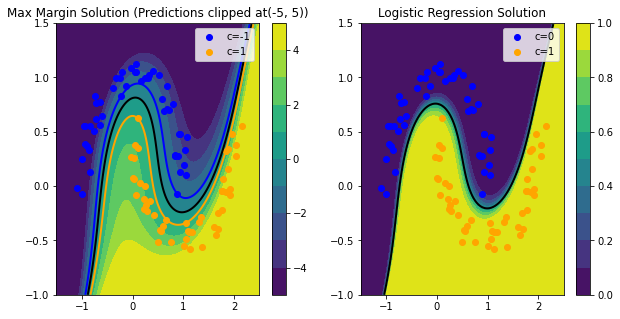

In [13]:

## plot train, contour, decision boundary and margins 

x_plt_range = np.arange(-1.5, 2.5, 0.01)
y_plt_range = np.arange(-1, 1.5, 0.01)
plt_grid = np.stack(np.meshgrid(x_plt_range, y_plt_range), axis=-1)
flat_plt_grid = np.reshape(plt_grid, [-1, 2])
plt_grid_shape = plt_grid.shape[:2]

plt.figure(figsize=(10, 5))
############### Plot SVM Result ###################

plt.subplot(1, 2, 1)
plt.title("Max Margin Solution (Predictions clipped at(-5, 5))")

pred_grid_svm = np.reshape(cubic_feature_fn(flat_plt_grid) @ w_svm, plt_grid_shape)
pred_grid_svm = np.clip(pred_grid_svm, -5, 5)
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid_svm,
            levels=[-1, 0, 1], colors=('blue', 'black', 'orange'), linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid_svm, levels=10)

plt.colorbar()

s0 =plt.scatter(x=train_samples[train_labels_svm == -1, 0],
                y=train_samples[train_labels_svm == -1, 1], label="c=-1", c="blue")
s1 =plt.scatter(x=train_samples[train_labels_svm == 1, 0], 
                y=train_samples[train_labels_svm == 1, 1], label="c=1", c="orange")
plt.legend()

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)

############### Plot Logistic Regression Result ###################
plt.subplot(1, 2, 2)
plt.title("Logistic Regression Solution")

pred_grid_lr = np.reshape(sigmoid(cubic_feature_fn(flat_plt_grid) @ w_lr), plt_grid_shape)
plt.contour(plt_grid[..., 0], plt_grid[..., 1], pred_grid_lr,
            levels=[0, 0.5, 1], colors=('blue', 'black', 'orange'), linestyles=('-',), linewidths=(2,))
plt.contourf(plt_grid[..., 0], plt_grid[..., 1], pred_grid_lr, levels=10)

plt.colorbar()

s0 =plt.scatter(x=train_samples[train_labels == 0, 0],
                y=train_samples[train_labels == 0, 1], label="c=0", c="blue")
s1 =plt.scatter(x=train_samples[train_labels == 1, 0], 
                y=train_samples[train_labels == 1, 1], label="c=1", c="orange")
plt.legend()

plt.xlim(-1.5, 2.5)
plt.ylim(-1, 1.5)

plt.show()